# **Tutorial - Zero-Loss Peak Subtraction using PyTorch**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LHCfitNikhef/ML4PA/blob/master/tutorials/tutorial-TEM/EELS_tutorial.ipynb)

## Using Google Colab

An easy way of running the code in this notebook is by using Google Colab. It uses the CPUs/GPUs at Google and comes with a lot of pre-installed packages. Just click the "Open in Colab" button above to get started.

## Motivation

In this tutorial, we will be developing a model-independent way of removing the zero-loss peak (ZLP) from an EEL spectrum. The ZLP often overwhelms the contributions associated to inelastics scatterings off the specimen. Therefore, relevant signals of low-loss phenomena (such as excitions and phonons) risk becoming drowned in the ZLP tail. An accurate removal of the ZLP contribution is thus crucial in order to chart and identify these features.

Spectral images in Electron Energy Loss Spectroscopy (EELS) are two-dimensional sets of spectra. To simplify our lives, we will be analysing only a subset of the whole spectral image with similar thickness. This way we make sure that the underlying ZLPs at different pixels acrross our subset are more or less similar.

Let us start by getting a feel of what our data looks like by loading it. 

## Loading the data

First of all, we must install and import a couple of modules.

In [1]:
#load external packages

#uncomment the three lines below to download the spectral images and two python modules that we need
!pip install ncempy
#!wget https://github.com/LHCfitNikhef/ML4PA/raw/master/tutorials/tutorial-TEM/area03-eels-SI-aligned.dm4
#!wget https://raw.githubusercontent.com/LHCfitNikhef/ML4PA/master/tutorials/tutorial-TEM/imageClass.py
#!wget https://raw.githubusercontent.com/LHCfitNikhef/ML4PA/master/tutorials/tutorial-TEM/trainZLP.py

from ncempy.io import dm
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

import imageClass as EELSImage
import trainZLP as ZLPnn

Once we have downloaded our spectral image, we can use it to create a python object `im` that contains all the relevant info that we need throughout this tutorial.

In [2]:
path_to_dm4 = 'area03-eels-SI-aligned.dm4'
im = EELSImage.Spectral_image.load_data(path_to_dm4)

## Plotting our data

Visualsing our data sounds like an obvious next step, which can be easily done in just a few lines of code. Try changing the location of `loc_x` and `loc_y` to see how the spectrum varies accross the image.

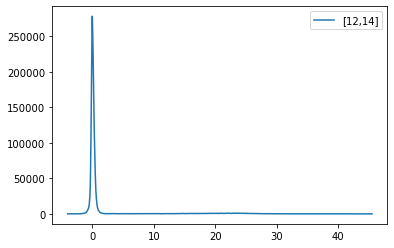

In [3]:
full_width, full_height = im.image_shape[1], im.image_shape[0]
loc_x, loc_y = int(0.1 * full_width), int(0.15 * full_height)
spectrum = im.plot_spectrum(loc_y, loc_x)

Next, we want to select only a subset of the entire image as our training data. It is important that the selected `window` covers pixels of more or less the same thickness. Running the cell below produces a heatmap of the integrated intensity accross the image, as well as a close-up of your selection. 

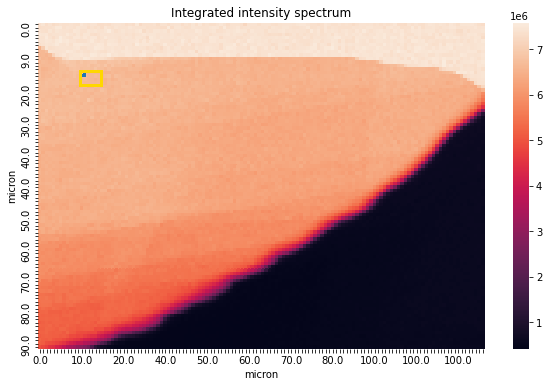

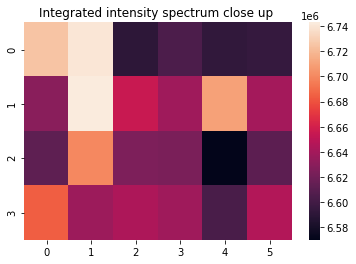

In [4]:
xmin, width = int(0.1 * full_width), int(0.05 * full_width)
ymin, height = int(0.15 * full_height), int(0.05 * full_height)

window = np.array([[xmin, width], [ymin, height]])
im.show_image(selection = window, pixel_highlight = [loc_x, loc_y])

## Selecting our training data

We cannot use the entire spectrum to train the ZLP, since low-loss features start to kick in relatively soon. Therefore, we construct three regions to further split up our training set. For energy losses $\Delta E \leq \Delta E_I$ (region 1), the ZLP dominates over the inelastic scatterings and so we can safely use this as our training data. For $\Delta E \geq \Delta E_{II}$ we use pseudo-data that drive the ZLP to zero (as it should). The EELS measurements in region 2, defined by $\Delta E_{I} \leq \Delta E \leq \Delta E_{II}$ are exclused from the training dataset.

To find "good" values of $\Delta E_I$ and $\Delta E_{II}$, we first need to smooth our data.

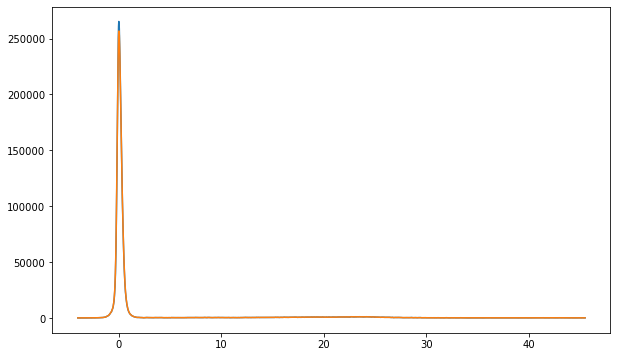

In [5]:
data_zoomed_concat = np.reshape(im.data_zoomed, (-1, im.l))
data_smooth = ZLPnn.smooth(data_zoomed_concat, window_len = 10)

# show the effect of smoothing on the second to last pixel
plt.figure(figsize=(10,6))
plt.plot(im.deltaE, im.data_zoomed[-1, -2, :])
plt.plot(im.deltaE, data_smooth[-2,:])
plt.show()

In the ultra-low loss region, characterised by $\Delta E \simeq$ few eV, the contributions of the ZLP and those from inealstic interactions become comparable. As a crude measure of where this region starts, we decide to look slightly to the left of the first local minimum in the EELS spectrum.

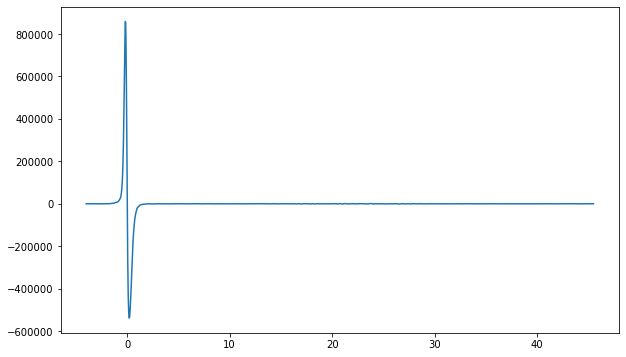

In [6]:
def der_spect(image, spectrum):
    dx = image.ddeltaE
    der_spectrum = (spectrum[:,1:]-spectrum[:,:-1])/dx
    return der_spectrum

der = der_spect(im, data_smooth)
der_smooth = ZLPnn.smooth(der, window_len = 10)

# plot the slope of the EELS spectrum
plt.figure(figsize=(10,6))
plt.plot(im.deltaE[:-1], der_smooth[-1,:])
plt.show()

Now we are ready to find $\Delta E_{I}$ and $\Delta E_{II}$

In [7]:
data_avg = np.average(data_smooth, axis=0)
der_avg = np.average(der, axis=0)

dE1 = ZLPnn.find_dE1(im, der_avg, data_avg, fct=0.7)


times_dE1 = 3 # multiplicative factor that determines the location of dE2
min_dE2 = im.deltaE.max() - im.ddeltaE * im.l * 0.05 
dE2 = np.minimum(dE1 * times_dE1, min_dE2) 

In [8]:
# selection indices 
select1 = len(im.deltaE[im.deltaE < dE1]) 
select2 = len(im.deltaE[im.deltaE > dE2])

## Rescaling our training data

To avoid our neurons from getting saturated and giving very small gradients, we will standardize our input features to zero mean and unit variance. This will significantly speed up the training of our neural network.

In [9]:
# Due to noise we have have some negative intensities. Set these to epsilon by hand.
epsilon = 1e-3
data_zoomed_concat[data_zoomed_concat < 0] = epsilon

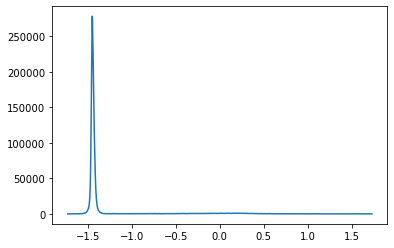

In [10]:
def rescale(data, mean, std):
    return (data - mean) / std

deltaE_scaled = rescale(im.deltaE, np.mean(im.deltaE), np.std(im.deltaE))

plt.plot(deltaE_scaled, data_zoomed_concat[0])

The cuts $\Delta E_I$ and $\Delta E_{II}$ still need to be applied though. Let us do this now and plot the result (we now plot the log of the intensity instead).

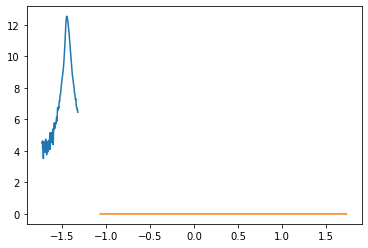

In [11]:
# input features
data_x = np.ones(select1 + select2)
data_x[:select1] = deltaE_scaled[:select1]
data_x[-select2:] = deltaE_scaled[-select2:]

# error on measured data
ci_low = np.nanpercentile(np.log(data_zoomed_concat), 16, axis=0)
ci_high = np.nanpercentile(np.log(data_zoomed_concat), 84, axis=0)
sigma = np.absolute(ci_high - ci_low)

data_sigma = sigma[:select1]
data_sigma = np.append(data_sigma, 0.8 * np.ones(select2))

# select a representative spectrum and plot 
data_y = np.log(data_zoomed_concat[0][:select1])
data_y = np.append(data_y, np.zeros(select2))
plt.plot(data_x[:select1], data_y[:select1])
plt.plot(data_x[-select2:], data_y[-select2:])

In [12]:
data_sigma

array([0.75780132, 0.56967704, 1.74709971, ..., 0.8       , 0.8       ,
       0.8       ])

## Training and validation set

We should be careful not to overfit our training data. That is, fitting noise rather than the true underlying physical law. A common way of avoiding this is to split our data into two sets: a training set on which we train our model, and a validation set on which we evaluate our model performances.

As an example, study the following code snippet that splits our spectrum randomly into two sets, the training and the validation set.

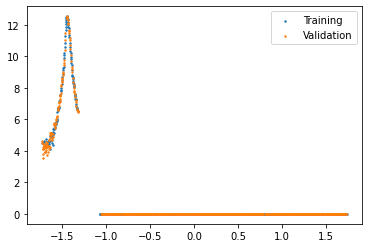

In [13]:
train_x, val_x, train_y, val_y, train_sigma, val_sigma = train_test_split(data_x, data_y, data_sigma, test_size=0.5)

# plot the training set
plt.scatter(train_x[np.argsort(train_x)], train_y[np.argsort(train_x)], s=2, label = 'Training')

# plot the validation set
plt.scatter(val_x[np.argsort(val_x)], val_y[np.argsort(val_x)], s=2, label = 'Validation')

plt.legend()


## Constructing the Neural Network

After all this data preprocessing work, it is time to start constructing the neural network and to train it!

Replica 0, Epoch 1, Training loss 8237.846495727135, Validation loss 8535.374758323727
Replica 0, Epoch 500, Training loss 80.78758757658383, Validation loss 63.26292403583016
Replica 0, Epoch 1000, Training loss 79.64580991513041, Validation loss 61.2775483638805
Replica 0, Epoch 1500, Training loss 79.33267482193365, Validation loss 61.1317159165926
Replica 0, Epoch 2000, Training loss 79.0920073411096, Validation loss 60.58541131282755
Replica 0, Epoch 2500, Training loss 78.88311128508437, Validation loss 60.390198314736445
Replica 0, Epoch 3000, Training loss 122.01930970654544, Validation loss 114.02135305747665
Replica 0, Epoch 3500, Training loss 79.72617497818753, Validation loss 61.319132644371464
Replica 0, Epoch 4000, Training loss 79.08663988740359, Validation loss 60.62312905053615
Replica 0, Epoch 4500, Training loss 78.71671097556177, Validation loss 60.21491764627708
Replica 0, Epoch 5000, Training loss 78.5233045969729, Validation loss 59.996191471200106
Replica 0, Ep

Replica 4, Epoch 2500, Training loss 0.268801662255979, Validation loss 0.392136229071597
Replica 4, Epoch 3000, Training loss 0.3687609990857441, Validation loss 0.4455749360279902
Replica 4, Epoch 3500, Training loss 0.26444989116536366, Validation loss 0.3864516651699486
Replica 4, Epoch 4000, Training loss 0.20396369403038436, Validation loss 0.26902625907896066
Replica 4, Epoch 4500, Training loss 0.1985111425687258, Validation loss 0.24390654482129626
Replica 4, Epoch 5000, Training loss 0.2172062509949909, Validation loss 0.30058934531621834
Replica 4, Epoch 5500, Training loss 0.2075103181808182, Validation loss 0.24798120214990887
Replica 4, Epoch 6000, Training loss 0.32006086557857183, Validation loss 0.4487047255537785
Replica 4, Epoch 6500, Training loss 0.278189628833885, Validation loss 0.4359634809358618
Replica 4, Epoch 7000, Training loss 0.2710179417217051, Validation loss 0.40384608030698915
Replica 4, Epoch 7500, Training loss 0.2016564320108568, Validation loss 0.

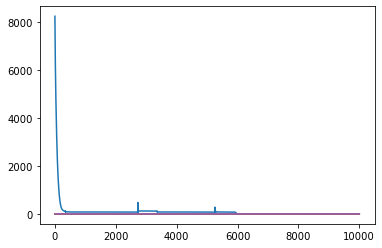

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import datetime

class MLP(nn.Module):

    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, 10)
        self.linear2 = nn.Linear(10, 15)
        self.linear3 = nn.Linear(15, 5)
        self.output = nn.Linear(5, num_outputs)
        self.tanh = nn.Tanh()
        #self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        x = self.tanh(x)
        x = self.linear3(x)
        x = self.tanh(x)
        x = self.output(x)
        return x
    
def loss_fn(output, target, error):
    loss = torch.mean(torch.square((output - target)/error))
    return loss

def weight_reset(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()
        
def training_loop(n_rep, n_epochs, optimizer, model, loss_fn):
    
    #data_x = deltaE_scaled[:select1]
    #data_sigma = im.data_unc[:select1]
    
    for rep in range(n_rep):
        
        #model.apply(weight_reset)
        
        path = './models/rep_{}'.format(rep)
        if not os.path.exists(path):
            os.makedirs(path)
        
        # load the log intensity of spectrum rep
        data_y = np.log(data_zoomed_concat[rep][:select1])
        data_y = np.append(data_y, np.zeros(select2))
       
        # create training and validation sets
        train_x, test_x, train_y, test_y, train_sigma, test_sigma = train_test_split(data_x, data_y, data_sigma, test_size=0.5)

        # convert numpy array to tensors and reshape
        train_x = torch.tensor(train_x).unsqueeze(-1)
        test_x = torch.tensor(test_x).unsqueeze(-1) 
        
        train_y = torch.tensor(train_y).unsqueeze(-1)
        test_y = torch.tensor(test_y).unsqueeze(-1)
        
        train_sigma = torch.tensor(train_sigma).unsqueeze(-1)
        test_sigma = torch.tensor(test_sigma).unsqueeze(-1)
        
        # define lists that keep track of the loss per epoch
        validation_loss = []
        training_loss = []
        
        loss_val_old = 0
        overfit_counter = 0
        patience = 100
        for epoch in range(1, n_epochs + 1):
            
            loss_train = 0.0
            loss_val = 0.0
            
            model_output = model(train_x.float())
            
            loss = loss_fn(model_output, train_y, train_sigma)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            loss_train += loss.item()
            training_loss.append(loss_train)
        
            #validation loss
            with torch.no_grad():
                model_output = model(test_x.float())
                val_loss = loss_fn(model_output, test_y, test_sigma)
                loss_val += val_loss.item()
                validation_loss.append(loss_val)
                assert val_loss.requires_grad == False
             
            if loss_val > loss_val_old and epoch > 1:
                overfit_counter += 1
            else:
                overfit_counter = 0
                
#             if overfit_counter == patience:
#                 torch.save(model.state_dict(), './models/rep_{}/trained_nn.pt'.format(rep))
#                 print("\n Overfitting detected! Training loss {}".format(loss_train))
#                 #best_epoch = epoch - patience
#                 break
                
            loss_val_old = loss_val
            
            
            if epoch == 1 or epoch % 500 == 0:
                print('Replica {}, Epoch {}, Training loss {}, Validation loss {}'.format(rep, epoch, loss_train, loss_val))
        
        torch.save(model.state_dict(), './models/rep_{}/trained_nn.pt'.format(rep))

        plt.plot(training_loss)

n_rep = im.data_zoomed.shape[0] * im.data_zoomed.shape[1]
n_epochs = 10000
model = MLP(num_inputs=1, num_outputs=1)
optimizer = optim.Adam(model.parameters(), lr=1e-2)                
                
training_loop(
    n_rep = 5,
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn
)

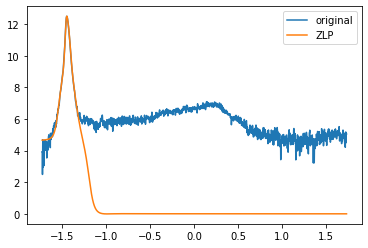

In [15]:
network_path = './models/rep_1/trained_nn.pt'
model.load_state_dict(torch.load(network_path))

deltaE_scaled_tensor = torch.tensor(deltaE_scaled).unsqueeze(-1)

model_pred = model.forward(deltaE_scaled_tensor.float())
model_pred = model_pred.detach().numpy()

plt.plot(deltaE_scaled, np.log(data_zoomed_concat[1]), label = 'original')
plt.plot(deltaE_scaled, model_pred, label = 'ZLP')
plt.legend()
plt.show()

## Evaluating the trained models

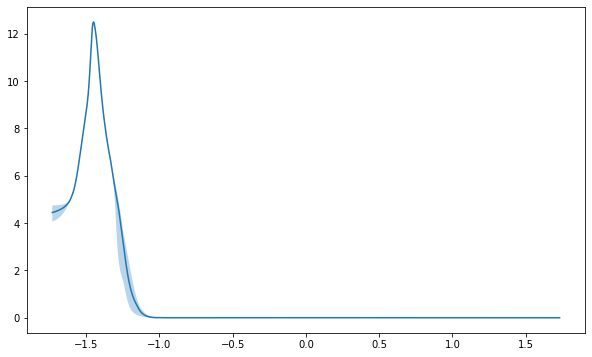

In [16]:
pred = []

for rep in range(4):
    network_path = './models/rep_{}/trained_nn.pt'.format(rep)
    model.load_state_dict(torch.load(network_path))
    
    model_pred = model.forward(deltaE_scaled_tensor.float())
    model_pred = model_pred.detach().numpy()
    pred.append(model_pred[:,0])

pred = np.array(pred)
pred_median = np.median(pred, axis=0)
cl_low = np.nanpercentile(pred, 16, axis=0)
cl_high = np.nanpercentile(pred, 84, axis=0)

plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
plt.plot(deltaE_scaled, pred_median)
ax.fill_between(deltaE_scaled, cl_low, cl_high, alpha = 0.3)
plt.show()

## ZLP subtraction

With the ZLP trained, we can now determine the subtracted spectrum.

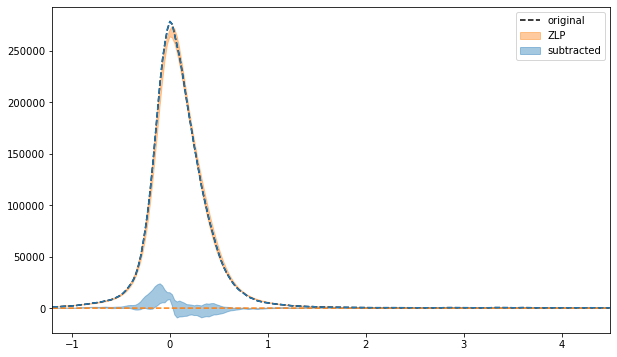

In [18]:
pred_I = np.exp(pred)
pred_I_med = np.median(pred, axis=0)
cl_low = np.nanpercentile(pred_I, 16, axis=0)
cl_high = np.nanpercentile(pred_I, 84, axis=0)

plt.figure(figsize=(10,6))
plt.plot(im.deltaE, data_zoomed_concat[0], linestyle='dashed', label='original', color='k')
plt.fill_between(im.deltaE, cl_low, cl_high, alpha = 0.4, label='ZLP', color='C1')
plt.plot(im.deltaE, pred_I_med, linestyle = 'dashed', color='C1')
plt.plot(im.deltaE, data_zoomed_concat[0] - pred_I_med, linestyle='dashed')
plt.fill_between(im.deltaE, data_zoomed_concat[0] - cl_low, data_zoomed_concat[0]- cl_high, alpha = 0.4, label='subtracted', color='C0')
plt.xlim(-1.2, 4.5)
plt.legend()
plt.show()

### Questions: 
1. Explain what would go wrong if instead we also include training data from region 2.

2. Try playing with different optimizers, architectures and learning rates to see how you can optimize the performances

3. Try to improve the way the stopping point is determined using the validaton set.

4. Try to implement different rescalings. Does the training improve if you rescale the features to lie between 0.1 and 0.9?

